In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Predicting thyroid cancer recurrence with deep learning


This project uses a [dataset](https://archive.ics.uci.edu/dataset/915/differentiated+thyroid+cancer+recurrence) consisting of 383 observations and 16 features (383x16 data matrix) based on the medical history of patients and one target feature representing the recurrence of previous thyroid cancer. In this project we used a deep neural network and compare its performance to the linear SVM that was trained on this dataset. We will interrogate questions on how to define the hyperparameter search space: That is epochs, batch size, number of hidden layers, and the widths of the layers. Theoretical justifications are cited for specific simplifications of this hyperparameter space for the sake of not incurring great computational cost. We implement a grid search of our defined hyperparameter space to select a DNN that maximizes the PR-AUC on a holdout set. Finally, we inspect the 5-fold PR-AUC of the selected model to examine the reliability of the performance.





# **(1)** Preprocessing and feature engineering

This section prepares the data for model generation. Missing values and outliers will be addressed. Encoding and ranking features, then some feature engineering.



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA





df=pd.read_csv('/content/Thyroid_Diff.csv') # Extract raw data

print(df.head()) # Display first 5 observations


   Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   
4   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology     Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     T   N   M Stage       Response Recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1  T1a  N0  M0  

# **(1.1)** Cleansing: Addressing missing values and outliers

The missing values are entirely in the "Response" column referring to the patient's response to previous treatment for cancer and the missing values are numerous. Feature importance bar charts in later sections show that response to previous treatment is consistently ranked as one of the most important features across various classification models. We will impute these missing values using a K-nearest neighbours model after feature engineering.

As for outliers, we will inspect the age column as it will be the only column that is not a rank-based or categorical. First, let's inspect how age is distributed so we can decide an appropriate method of outlier detection and removal.




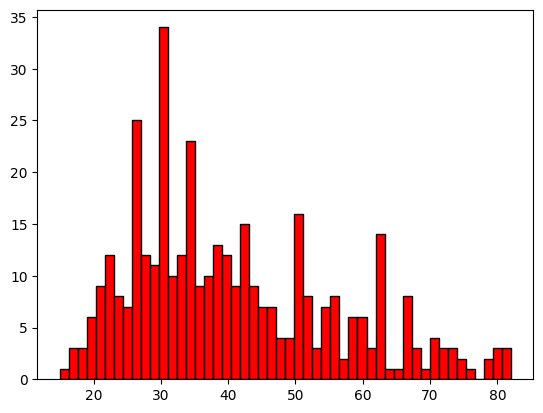

In [ ]:
plt.hist(df['Age'],bins=50, color='red',edgecolor='black')
plt.show()

This data is significantly skewed and doesn't appear normal. So we will use the IQR method for detection.

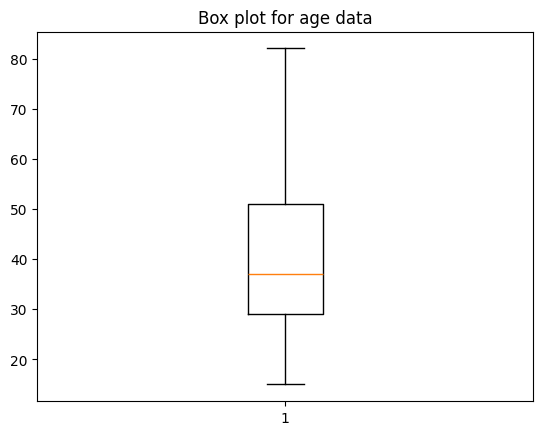

In [ ]:
plt.boxplot(df['Age'])
plt.title("Box plot for age data")
plt.show()

Our boxplot demonstrates that age does not have outliers.

# **(1.2)** Encoding, ranking, and normalizing (some) features.

*   Normalizing columns with a wide range of values like age. We will not normalize binary or rank-based features as we will only be using a few ranks for each rank-based feature. We want to maintain the distance between the ranks that we have assigned and not have it possibly distorted by normalization.
*   Extracting binary features (e.g, 0 or 1)
*   Extracting rank-based features (e.g, 1, 2, 3 ..)

The logic behind the rankings will be detailed extensively.









In [ ]:
df['Age']=(df['Age']-df['Age'].mean())/df['Age'].std()




*   Assign binary features 0 or 1
*   Hx means "History of"
*   "Recurred" is whether thyroid cancer has recurred or not
*   The "M" feature refers to metastasis
*   "Response" refers to response to cancer treatments. "Structural incomplete" means there are bodily displays of the cancer's persistence. "Biochemical incomplete" means there are biochemical signatures of the cancer's persistence. The indicators of the persistence are irrelevant so they both get a value of 1 for persistence. "Excellent" gets 0.
*  "N" represents how much the cancer has spread specifically in terms of what lymph nodes it has spread to. "N0" means there is no spread to nearby lymph nodes. "N1a" means there is spread to nearby lymph nodes but still contained in the central region. "N1b" means it has spread to the lateral neck. N0, N1a, N1b will be coded as 0,1,2, respectively.








In [ ]:
df['Gender']=df['Gender'].replace(['F','M'],[0,1])

df['Smoking']=df['Smoking'].replace(['No','Yes'],[0,1])

df['Hx Smoking']=df['Hx Smoking'].replace(['No','Yes'],[0,1])

df['Hx Radiothreapy']=df['Hx Radiothreapy'].replace(['No','Yes'],[0,1])

df['Recurred']=df['Recurred'].replace(['No', 'Yes'], [0,1])

df['M']=df['M'].replace(['M0', 'M1'], [0,1])

df['Response']=df['Response'].replace(['Structural Incomplete','Biochemical Incomplete', 'Excellent'], [1,1,0])

df['N']=df['N'].replace(['N0','N1a','N1b'],[0,1,2])

print(df['Response'].unique())

['Indeterminate' 0 1]




*   Thyroid function (or dysfunction) should be thought of purely in terms of
magnitude, not direction. That is, the hypo-hyper distinction should not be treated as information. What is treated as information is the magnitude. That is, the clinical-subclinical distinction. Euthyroid means it is a healthy thyroid and gets a value of 0. Subclinical and clinical dysunction gets values of 1 and 2 respectively.

* "Risk" is the risk of recurrence.
*   "T" refers to the magnitude of the primary tumour which is ranked numeric-alphabetically.
*   "Focality" is the number of distinct growths in the primary cancer site.
*   "Adenopathy" is swelling of the lymph node. Here, we apply the same logic with ranking thyroid function/dysfunction. But with "bilateral", both directions suggest another order of magnitude. "Extensive" is the maximum rank.
* "Stage" is the stage of the previous cancer
*   "Physical Examination" is the kind of goiter found in a physical examination.
*  "Pathology" is the type of cancer found. These could be ranked in terms of size and aggression, so I created two new features. "Pathologic size" is pathology ranked by size. "Pathologic aggression" is pathology ranked by aggression.












In [ ]:
df['Thyroid Function']=df['Thyroid Function'].replace(['Clinical Hypothyroidism', 'Subclinical Hypothyroidism', 'Euthyroid', 'Subclinical Hyperthyroidism','Clinical Hyperthyroidism'], [2,1,0,1,2])
# Rename column
df['Thyroid Dysfunction']=df['Thyroid Function']
df=df.drop(columns='Thyroid Function', axis=1)

df['Risk']=df['Risk'].replace(['Low', 'Intermediate', 'High'], [1,2,3])

df['T']=df['T'].replace(['T1a', 'T1b', 'T2a', 'T2', 'T2b', 'T3a', 'T3b', 'T4a', 'T4b'], range(1,10))

df['Focality']=df['Focality'].replace(['Uni-Focal','Multi-Focal'], [1,2])

df['Adenopathy']=df['Adenopathy'].replace(['No','Left','Right','Posterior','Bilateral','Extensive'],[1,2,2,2,3,4])

df['Stage']=df['Stage'].replace(['I', 'II', 'III', 'IVA', 'IVB'], range(1,6))

df['Physical Examination']=df['Physical Examination'].replace(['Normal','Single nodular goiter-right', 'Single nodular goiter-left', 'Diffuse goiter', 'Multinodular goiter'],[0,1,1,1,2])

df['Pathologic size']=df['Pathology']

df['Pathologic aggression']=df['Pathology']

df['Pathologic size']=df['Pathology'].replace(['Micropapillary', 'Papillary', 'Follicular', 'Hurthel cell'], [1,2,3,4])

df['Pathologic aggression']=df['Pathology'].replace(['Micropapillary', 'Papillary', 'Follicular', 'Hurthel cell'], [2,1,3,4])


df=df.drop(columns=['Pathology'])
df.reset_index(inplace=True)


In [ ]:
print(df.head())

   index       Age  Gender  Smoking  Hx Smoking  Hx Radiothreapy  \
0      0 -0.916241       0        0           0                0   
1      1 -0.453721       0        0           1                0   
2      2 -0.718018       0        0           0                0   
3      3  1.396357       0        0           0                0   
4      4  1.396357       0        0           0                0   

   Physical Examination  Adenopathy  Focality  Risk  T  N  M  Stage  \
0                     1           1         1     1  1  0  0      1   
1                     2           1         1     1  1  0  0      1   
2                     1           1         1     1  1  0  0      1   
3                     1           1         1     1  1  0  0      1   
4                     2           1         2     1  1  0  0      1   

        Response  Recurred  Thyroid Dysfunction  Pathologic size  \
0  Indeterminate         0                    0                1   
1              0         0  

# **(1.3)** KNN Imputation

Missing values in the "Response" representing response to previous cancer is represented by "Indeterminate". A new dataframe (named rdf) removing these missing values will be used to train the KNN imputer.

We use KNN imputation here for the same reason it was used in the SVM classification. Response was shown to be a highly important predictor, so we don't remove the information.

In [ ]:
KNN_imputer=KNeighborsClassifier()
rdf=df[df['Response']!='Indeterminate'] #rdf means dataframe with removed values. This will be used to train the KNN_imputer

yf=rdf['Response'].astype(int)
Xf=rdf.drop(columns=['Response', 'Recurred']) # Both target and column used for imputation gets removed

KNN_imputer.fit(Xf,yf)
df['Response']=df['Response'].replace(['Indeterminate'], [KNN_imputer.predict(df.drop(columns=['Response', 'Recurred'],axis=1))])

# **(1.4)** Feature engineering: Introducing interaction and polynomial terms.

Interactions between response, risk, and age will be explored in this model.

In [ ]:
df['Response x Age']=df['Response']*df['Age']
df['Response x Age^2']=df['Response']*df['Age']**2
df['Response x Risk']=df['Response']*df['Risk']
df['Response x Risk^2']=df['Response']*df['Risk']**2
df['Response x Age x Risk']=df['Response']*df['Age']*df['Risk']

# **(2.1)** Defining the feautures and target. Implement train_test_split.

**A note on our selected features in X:**

Performing feature selection with deep learning models is extremely computationally expensive. We justify the feature selection used in the original SVM model for this data on the following theoretical basis.

Yes, in general it is possible that higher order features formed from singularly unimportant features could become important. We argue that it does not apply in this context because with a dataset of only 383 observations, we are running significant risk of overfitting. The risk of overfitting isn't worth it when the DNN is shown later on to achieve extremely high metrics anyways. Using the simplified feature selection, we maintain greater interpretability and stratospheric performance at the same time.  



In [ ]:
from sklearn.model_selection import train_test_split

print(df.keys())

y=df['Recurred']


X=df[['Gender', 'Smoking', 'N', 'M', 'Response', 'Response x Risk', 'Response x Risk^2']] # Final feature selection from the linear SVM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Index(['index', 'Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Physical Examination', 'Adenopathy', 'Focality', 'Risk', 'T', 'N', 'M',
       'Stage', 'Response', 'Recurred', 'Thyroid Dysfunction',
       'Pathologic size', 'Pathologic aggression', 'Response x Age',
       'Response x Age^2', 'Response x Risk', 'Response x Risk^2',
       'Response x Age x Risk'],
      dtype='object')


# **Hyperparameter Tuning**

(1) **Generalized Hyperparameter**

We have a multi-dimensional hyperparameter represented as

$$H=(E,B,L,\textbf{v}) \in \mathbb{N}^{3}\times\mathbb{N}^{L}$$

with the maximization problem

$$\underset{H \in \mathbb{H}}{argmax} \hspace{0.1cm} f(H)$$

Where $E$ are epochs, $B$ is batch size, $L$ is the number of hidden layers, and $\textbf{v}$ is the vector of the widths of the layers. $f(H)$ is our objective function which is the PR_AUC score on a holdout set.


(2) **Narrowing the hyperparameter space**

Training these models is very expensive computationally and cost significant time. Here we will impose and justify theoretical restrictions on the hyperparameter space to make our search simpler and more efficient.



*   Make the entries (widths of hidden layers) of $\textbf{v}$ a geometrically decreasing sequence. That is, the widths of each layer get geometrically narrower. $\textbf{v}(L)=(2^{L},2^{L-1},\dots,2)$ followed by the singular activation neuron. We do this avoid overfitting risk with a relatively smaller dataset we are working with. We are achieving higher abstraction but narrowing the features.
* Restrict $L$ space to $L \in \{2,3,4\}$ as DL models in the medical literature normally have only a few (2 to 4) hidden layers.
*   Restrict the $B$ space to $B \in \{16,32,64\}$. These are the standard batch sizes used to train medical models.
*   Our dataset is only in the hundreds, so we need to restrict our epochs $E$ a narrower range of small values to avoid overfitting. We impose the restriction
$E \in \{50,75,100\}$. Epochs of these sizes are typically seen in the medical literature.

So

$$H=(E,B,L,\textbf{v}(L))$$











In [ ]:
def DNN_LR(L, input_dim): # Initialize a DNN based on L (hidden layers)
  model=Sequential()
  model.add(Input(shape=(input_dim,)))

  for k in range(0,L): model.add(Dense(2**(L-k), activation='relu')) # Create the layers based on v(L)

  model.add(Dense(1, activation='sigmoid'))
  return model

In [ ]:
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Assume input_dim is the dimension of your input features
input_dim = X_train.shape[1]

H_space={ # Hyperparameter space
    'E': [50,75,100],
    'B': [16,32,64],
    'L': [2,3,4]
}

import itertools
from sklearn.metrics import precision_recall_curve, auc

param_combinations = itertools.product(H_space['E'], H_space['B'], H_space['L']) # Get all possible H combinations

PR_AUC={}

for E,B,L in param_combinations:
  model=DNN_LR(L, input_dim)

  model.compile(
      optimizer=Adam(1e-3),
      loss="BinaryCrossentropy",
      metrics=['precision', 'recall']
  )

# Labels must be -1 or +1
  model.fit(X_train, y_train, epochs=E, batch_size=B, verbose=0)
  from sklearn.metrics import precision_recall_curve, auc

  y_scores = model.predict(X_test).ravel()

  precision, recall, _ = precision_recall_curve(y_test, y_scores)

  pr_auc = auc(recall, precision)
  PR_AUC[(E,B,L)]=pr_auc
  print(f"PR AUC: {pr_auc:.4f}", "With H="+str([E,B,L]))


best_H = max(PR_AUC, key=PR_AUC.get)
best_score = PR_AUC[best_H]

print("Best Hyperparameter Configuration (H):", best_H)
print("Highest PR_AUC:", best_score)




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PR AUC: 0.5498 With H=[50, 16, 2]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
PR AUC: 0.9794 With H=[50, 16, 3]


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
PR AUC: 0.9868 With H=[50, 16, 4]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PR AUC: 0.9546 With H=[50, 32, 2]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PR AUC: 0.9750 With H=[50, 32, 3]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
PR AUC: 0.9841 With H=[50, 32, 4]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
PR AUC: 0.9894 With H=[50, 64, 2]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PR AUC: 0.9794 With H=[50, 64, 3]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
PR AUC: 0.4916 With H=[50, 64, 4]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
PR AUC: 0.9720 With H=[75, 16, 2]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
PR AUC: 0.5832 With H=[75, 16, 3]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
PR AUC: 0.9640 With H=[75, 16, 4]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
PR AUC: 0.9825 With H=[75, 32, 2]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PR AUC: 0.9813 With H=[75, 32, 3]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
PR AUC: 0.9794 With H=[75, 32, 4]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PR AUC: 0.9807 With H=[75,

So,

$$\underset{H \in \mathbb{H}}{argmax} \hspace{0.1cm} f(H)=(50,64,2,\textbf{v}(2))=H_{*}$$
$$f(H_{*})=98.94\%$$

This is only slightly better than our 97% of our linear SVM. Meaning, higher order features contribute minimal information.

Finally, we will inspect the 5-fold CV of this model on the PR-AUC metric.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
import numpy as np
import tensorflow as tf

In [ ]:
from sklearn.model_selection import StratifiedKFold
X=np.array(X)

# Data: X (features), y (labels)
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
pr_aucs = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold+1}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model=DNN_LR(2, input_dim)

    model.compile(
      optimizer=Adam(1e-3),
      loss="BinaryCrossentropy",
      metrics=['precision', 'recall']
  )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    y_pred = model.predict(X_val).ravel()
    pr_auc = average_precision_score(y_val, y_pred)
    print(f"Fold {fold+1} PR_AUC: {pr_auc:.4f}")
    pr_aucs.append(pr_auc)

print(f"\nMean , STD of PR_AUC: {np.mean(pr_aucs):.4f}, {np.std(pr_aucs):.4f}")


Fold 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Fold 1 PR_AUC: 0.9619
Fold 2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Fold 2 PR_AUC: 0.9318
Fold 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Fold 3 PR_AUC: 0.9686
Fold 4
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Fold 4 PR_AUC: 0.9296
Fold 5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Fold 5 PR_AUC: 0.8585

Mean , STD of PR_AUC: 0.9301, 0.0390


Across the 5 folds, we have an average PR-AUC of 93.01% and a standard deviation of 3.90%. We display a histogram of the PR-AUC scores. This shows that our model performs at a high level consistently.

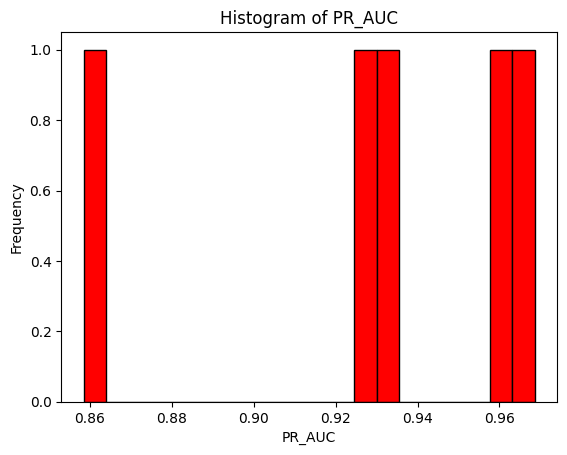

In [ ]:
plt.hist(pr_aucs, bins=20, color='red',edgecolor='black')
plt.xlabel('PR_AUC')
plt.ylabel('Frequency')
plt.title('Histogram of PR_AUC')
plt.show()